In [1]:
%matplotlib inline
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_row', 12)

In [3]:
speeches =  pd.read_csv('speeches.csv')[['president', 'transcript', 'date']]
speeches['transcript'] = speeches['transcript'].apply(str)
speeches['date'] = pd.to_datetime(speeches['date'])

In [4]:
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
remove_punctuation_map = dict.fromkeys(map(ord, string.punctuation))

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

def normalize(text):
    # remove punctuation, lowercase, stem
    return stem_tokens(word_tokenize(text.lower().replace('—', ' ').translate(remove_punctuation_map)))

In [5]:
speeches_by_pres = speeches.groupby('president')['transcript'].apply(lambda x: ' '.join(x)).to_frame()

In [6]:
speeches_by_pres['year'] = speeches.groupby('president')['date'].apply(
    lambda x: sum(x.apply(lambda y: y.year)) // len(x)
    ).to_frame()['date']

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline

hasher = HashingVectorizer(tokenizer=normalize,
                           stop_words=stem_tokens(ENGLISH_STOP_WORDS),
                           non_negative=True,
                           norm=None,
                           binary=False)


vectorizer = make_pipeline(hasher, TfidfTransformer())

In [8]:
tfidf = vectorizer.fit_transform(speeches_by_pres['transcript'])

In [9]:
#number of unique words
np.unique(tfidf.nonzero()[1]).shape

(33389,)

# Raw PCA

In [10]:
from sklearn.decomposition import PCA

data_pca = PCA(2).fit_transform(tfidf.toarray())
speeches_by_pres['projection1'], speeches_by_pres['projection2'] = data_pca.T

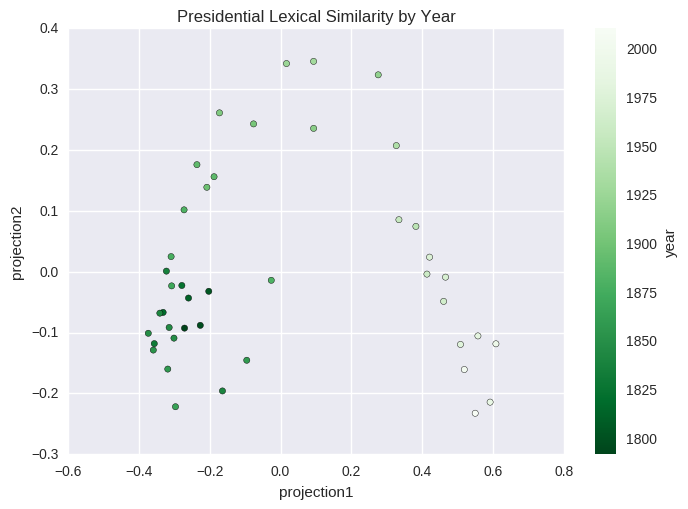

In [11]:
fig, ax = plt.subplots()

speeches_by_pres.plot('projection1', 'projection2', kind='scatter', c='year', cmap='Greens_r', ax=ax)

ax.set_title('Presidential Lexical Similarity by Year')

plt.savefig('figs/raw_pca.png', bbox_inches='tight')

# Clustered Data

In [12]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(3, affinity='cosine', linkage='complete')
speeches_by_pres['cluster'] = ac.fit_predict(tfidf.toarray())

In [13]:
for idx, i in enumerate(speeches_by_pres['cluster'].unique()):
    print(idx, speeches_by_pres[speeches_by_pres['cluster'] == idx].index.unique())

0 ['Abraham Lincoln' 'Andrew Jackson' 'Andrew Johnson' 'Benjamin Harrison'
 'Chester Arthur' 'Franklin Pierce' 'George Washington' 'Grover Cleveland'
 'James Buchanan' 'James Garfield' 'James Madison' 'James Monroe'
 'James Polk' 'John Adams' 'John Quincy Adams' 'John Tyler'
 'Martin Van Buren' 'Millard Fillmore' 'Rutherford Hayes'
 'Theodore Roosevelt' 'Thomas Jefferson' 'Ulysses Grant' 'William Harrison'
 'William McKinley' 'William Taft' 'Zachary Taylor']
1 ['Barack Obama' 'Bill Clinton' 'George H. W. Bush' 'George W. Bush'
 'Gerald Ford' 'Jimmy Carter' 'John Kennedy' 'Lyndon Johnson'
 'Richard Nixon' 'Ronald Reagan']
2 ['Calvin Coolidge' 'Dwight Eisenhower' 'Franklin Roosevelt' 'Harry Truman'
 'Herbert Hoover' 'Warren Harding' 'Woodrow Wilson']


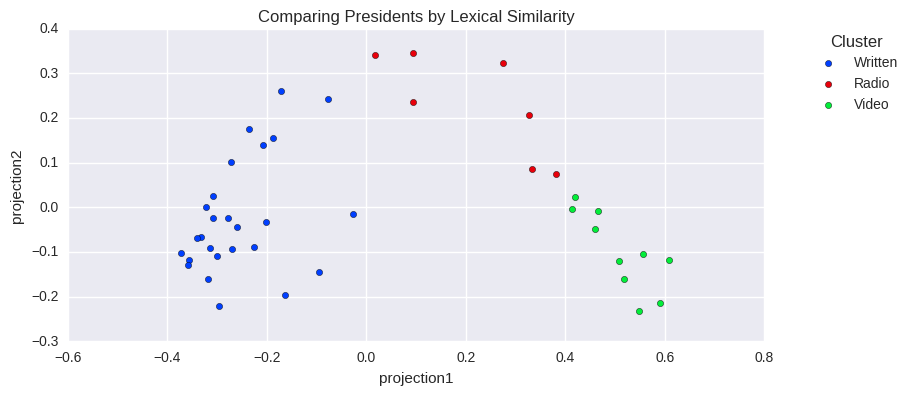

In [14]:
g = sns.FacetGrid(speeches_by_pres, hue="cluster", palette='bright', size=4, aspect=2)
g.map(plt.scatter, "projection1", "projection2", linewidths=.3, edgecolors='black')

handles, _ = g.ax.get_legend_handles_labels()
myorder = [0,2,1]
handles = [handles[i] for i in myorder]
labels = ['Written','Radio','Video']
g.ax.legend(handles, labels, title='Cluster', borderaxespad=0., bbox_to_anchor=(1.2, 1))

g.ax.set_title('Comparing Presidents by Lexical Similarity')

g.savefig('figs/lexical_similarity.png', bbox_inches='tight')